In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# 1. Prepare CIFAR-10 Data
# ==========================================
print("Downloading and loading CIFAR-10 dataset...")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Normalize images to [-1, 1] to match the previous PyTorch scaling
x_train = (x_train.astype('float32') / 127.5) - 1.0
x_test = (x_test.astype('float32') / 127.5) - 1.0

# Keras handles batching natively during model.fit(), 
# but we can optionally pre-batch using tf.data for performance
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(128)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(128)

2026-02-20 11:04:14.964572: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3
2026-02-20 11:04:14.964653: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-02-20 11:04:14.964725: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.92 GB
2026-02-20 11:04:14.964745: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-20 11:04:14.964789: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [2]:
# ==========================================
# 2. Define Custom 4-bit Quantized ReLU (with STE)
# ==========================================
@tf.custom_gradient
def int4_relu_ste(x):
    """
    FORWARD PASS: Apply ReLU, then quantize to 15 positive levels (UINT4).
    BACKWARD PASS: Straight-Through Estimator (STE)
    """
    # --- Forward Pass ---
    x_relu = tf.nn.relu(x)
    scale = 0.25  # Step size
    x_scaled = x_relu / scale
    x_rounded = tf.round(x_scaled)
    # Clamp between 0 and 15
    x_clamped = tf.clip_by_value(x_rounded, 0.0, 15.0)
    result = x_clamped * scale

    # --- Backward Pass (STE) ---
    def grad(upstream_gradient):
        # The derivative of ReLU is 1 for positive numbers and 0 for negative.
        # We create a mask of 1.0s and 0.0s based on the original input 'x'.
        mask = tf.cast(x > 0.0, dtype=tf.float32)
        # Pass the upstream gradient straight through, but kill it where x <= 0
        return upstream_gradient * mask

    return result, grad

# Wrap the custom operation in a Keras Layer so we can inject it into a model
class INT4ReLU(tf.keras.layers.Layer):
    def call(self, inputs):
        return int4_relu_ste(inputs)


In [25]:

# ==========================================
# 3. Define the Convolutional Neural Networks
# ==========================================
def create_standard_cnn():
    """A standard CNN using continuous 32-bit floating-point ReLU."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(10) # No softmax here; we'll use from_logits=True in the loss
    ])
    return model

def create_quantized_cnn():
    """The exact same CNN, but utilizing our 4-bit discrete staircase activation."""
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), padding='same', input_shape=(32, 32, 3)),
        INT4ReLU(), # Injected Custom Layer
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(64, (3, 3), padding='same'),
        INT4ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Conv2D(128, (3, 3), padding='same'),
        INT4ReLU(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512),
        INT4ReLU(),
        tf.keras.layers.Dense(10)
    ])
    return model


# ==========================================
# 4. Initialize and Calculate Memory Footprint
# ==========================================
model_std = create_standard_cnn()
model_qnt = create_quantized_cnn()

# Calculate parameters
total_params = model_std.count_params()
fp32_memory_mb = (total_params * 4) / (1024 ** 2)
int4_memory_mb = (total_params * 0.5) / (1024 ** 2)

print(f"\nModel Parameters: {total_params:,}")
print(f"Theoretical FP32 Memory: {fp32_memory_mb:.2f} MB")
print(f"Theoretical INT4 Memory: {int4_memory_mb:.2f} MB\n")


# ==========================================
# 5. Compile and Train the Models
# ==========================================
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model_std.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=loss_fn,
                  metrics=['accuracy'])

model_qnt.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss=loss_fn,
                  metrics=['accuracy'])

epochs = 10

print("--- Training Standard CNN (FP32) ---")
history_std = model_std.fit(train_ds, validation_data=test_ds, epochs=epochs,batch_size=256)

print("\n--- Training Quantized CNN (INT4) ---")
history_qnt = model_qnt.fit(train_ds, validation_data=test_ds, epochs=epochs,batch_size=256)


# Save the Standard FP32 CNN
model_std.save('models/standard_cnn.keras')
print("Standard model saved to standard_cnn.keras")

# Save the Quantized INT4 CNN
model_qnt.save('models/quantized_cnn.keras')
print("Quantized model saved to quantized_cnn.keras")


Model Parameters: 1,147,466
Theoretical FP32 Memory: 4.38 MB
Theoretical INT4 Memory: 0.55 MB

--- Training Standard CNN (FP32) ---
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.4820 - loss: 1.4451 - val_accuracy: 0.5956 - val_loss: 1.1465
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6395 - loss: 1.0302 - val_accuracy: 0.6503 - val_loss: 1.0107
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6749 - loss: 0.9563 - val_accuracy: 0.6718 - val_loss: 1.0181
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.6560 - loss: 1.1980 - val_accuracy: 0.6297 - val_loss: 1.6317
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5924 - loss: 2.9885 - val_accuracy: 0.5051 - val_loss: 6.0277
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5418 - loss: 15.4977 - val_accuracy: 0.5112 - val_loss: 28.3074
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.5225 - loss: 63.3274 - v

In [32]:
import tensorflow as tf

# 1. Loading the Standard Model (No custom layers)
loaded_std_model = tf.keras.models.load_model('standard_cnn.keras')
loaded_std_model.summary()
print("Successfully loaded Standard CNN.")

# 2. Loading the Quantized Model (Requires custom_objects)
# We must map the string name of the layer to the actual Python class we defined earlier
loaded_qnt_model = tf.keras.models.load_model(
    'quantized_cnn.keras',
    custom_objects={'INT4ReLU': INT4ReLU}
)
loaded_std_model.summary()
print("Successfully loaded Quantized CNN with custom INT4 layers.")

# Assuming you have a batch of test images ready
sample_images = x_test[:5]

# Get the actual ground-truth labels for those exact 5 images
# We use .flatten() to convert it from shape (5, 1) to a clean (5,) array
real_values = y_test[:5].flatten()

# Run predictions on the loaded Standard model
predictions_std = loaded_std_model.predict(sample_images)
# Run predictions on the loaded Quantized model
predictions_qnt = loaded_qnt_model.predict(sample_images)

# Convert raw logits (probabilities) into actual class labels (0-9)
predicted_classes_std = tf.argmax(predictions_std, axis=1).numpy()
predicted_classes_qnt = tf.argmax(predictions_qnt, axis=1).numpy()

print(f"Predicted CIFAR-10 classes (Standard):  {predicted_classes_std} || Real value: {real_values}")
print(f"Predicted CIFAR-10 classes (Quantized): {predicted_classes_qnt} || Real value: {real_values}")

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,442,400 (13.13 MB)

 Trainable params: 1,147,466 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,294,934 (8.75 MB)

Successfully loaded Standard CNN.


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,442,400 (13.13 MB)

 Trainable params: 1,147,466 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,294,934 (8.75 MB)

Successfully loaded Quantized CNN with custom INT4 layers.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Predicted CIFAR-10 classes (Standard):  [3 1 8 0 6] || Real value: [3 8 8 0 6]
Predicted CIFAR-10 classes (Quantized): [3 8 8 8 6] || Real value: [3 8 8 0 6]



Generating side-by-side training plots...
Saved -> cifar10_tf_accuracy_side_by_side.png


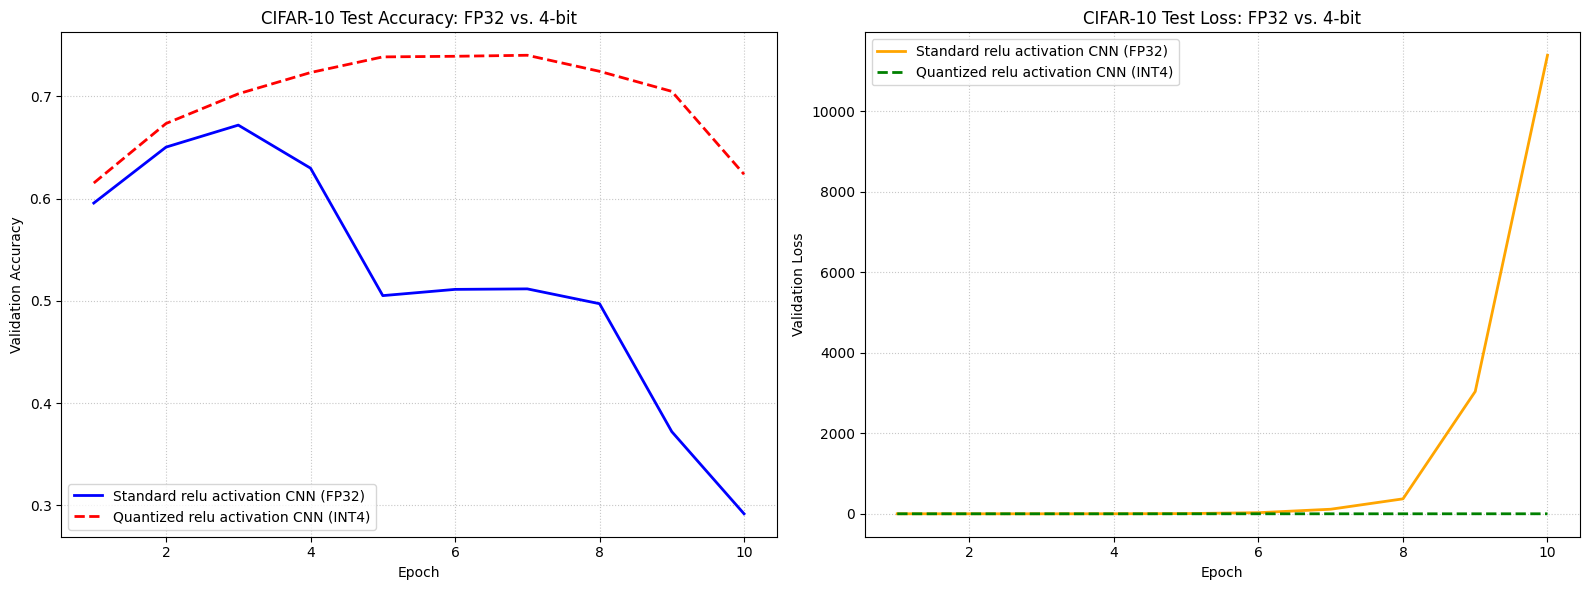

In [34]:
import matplotlib.pyplot as plt

# ==========================================
# 6. Visualize the Accuracy Results (Side-by-Side)
# ==========================================
print("\nGenerating side-by-side training plots...")

# Create a figure with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- Plot 1: Validation Accuracy ---
ax1.plot(range(1, epochs + 1), history_std.history['val_accuracy'], 
         label="Standard relu activation CNN (FP32)", linewidth=2, color='blue')
ax1.plot(range(1, epochs + 1), history_qnt.history['val_accuracy'], 
         label="Quantized relu activation CNN (INT4)", linewidth=2, color='red', linestyle='--')
ax1.set_title("CIFAR-10 Test Accuracy: FP32 vs. 4-bit")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Validation Accuracy")
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.7)

# --- Plot 2: Validation Loss ---
ax2.plot(range(1, epochs + 1), history_std.history['val_loss'], 
         label="Standard relu activation CNN (FP32)", linewidth=2, color='orange')
ax2.plot(range(1, epochs + 1), history_qnt.history['val_loss'], 
         label="Quantized relu activation CNN (INT4)", linewidth=2, color='green', linestyle='--')
ax2.set_title("CIFAR-10 Test Loss: FP32 vs. 4-bit")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Validation Loss")
ax2.legend()
ax2.grid(True, linestyle=':', alpha=0.7)

# Final formatting and save
plt.tight_layout()
plt.savefig("cifar10_tf_accuracy_side_by_side.png", dpi=150)
print("Saved -> cifar10_tf_accuracy_side_by_side.png")

In [52]:
import tensorflow as tf
import matplotlib.pyplot as plt

# ==========================================
# 1. Load the Models
# ==========================================
# Loading the Standard Model (No custom layers)
loaded_std_model = tf.keras.models.load_model('standard_cnn.keras')
loaded_std_model.summary()
print("Successfully loaded Standard CNN.\n")

# Loading the Quantized Model (Requires custom_objects)
loaded_qnt_model = tf.keras.models.load_model(
    'quantized_cnn.keras',
    custom_objects={'INT4ReLU': INT4ReLU}
)
loaded_qnt_model.summary() # Fixed: Changed from std to qnt
print("Successfully loaded Quantized CNN with custom INT4 layers.\n")

# ==========================================
# 2. Run Standard Inference
# ==========================================
sample_images = x_test[:5]
real_values = y_test[:5].flatten()

# Run predictions
predictions_std = loaded_std_model.predict(sample_images, verbose=0)
predictions_qnt = loaded_qnt_model.predict(sample_images, verbose=0)

# Convert raw logits to actual class labels (0-9)
predicted_classes_std = tf.argmax(predictions_std, axis=1).numpy()
predicted_classes_qnt = tf.argmax(predictions_qnt, axis=1).numpy()

print(f"Predicted CIFAR-10 classes (Standard):  {predicted_classes_std} || Real value: {real_values}")
print(f"Predicted CIFAR-10 classes (Quantized): {predicted_classes_qnt} || Real value: {real_values}\n")

# ==========================================
# 3. Visualize the Activation Functions (Feature Maps)
# ==========================================
def plot_feature_maps(model, image, title, filename):
    """
    Creates a sub-model to extract and plot the intermediate activations 
    of the first convolutional block and saves the plot as a PNG.
    """
    # Create a feature extractor model that stops at the first few layers
    # (Extracts inputs and maps them directly to the target layer's outputs)
    extractor = tf.keras.models.Model(
        inputs=model.inputs, 
        outputs=[layer.output for layer in model.layers[:2]]
    )
    
    # Add a batch dimension to the single image: shape becomes (1, 32, 32, 3)
    img_batch = tf.expand_dims(image, axis=0)
    
    # Run the image through the extractor
    feature_maps = extractor.predict(img_batch, verbose=0)
    
    # Select the correct activation map:
    # Quantized model has INT4ReLU at layer index 1.
    # Standard model has continuous ReLU built natively into layer index 0.
    if len(model.layers) > 1 and 'int4' in model.layers[1].name.lower():
        act_map = feature_maps[1]
    else:
        act_map = feature_maps[0]
        
    # Plot the first 16 feature channels (out of 32) in a 4x4 grid
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(title, fontsize=16, fontweight='bold')
    
    for i, ax in enumerate(axes.flat):
        # act_map shape is (Batch, Height, Width, Channels) -> (1, 32, 32, 32)
        # We plot the i-th channel of the first image
        ax.imshow(act_map[0, :, :, i], cmap='viridis')
        ax.axis('off')
        
    plt.tight_layout()
    
    # -> SAVE THE IMAGE AS A PNG HERE <-
    # Using dpi=150 ensures the image is saved in high quality
    plt.savefig(filename, dpi=150)
    print(f"Saved plot to: {filename}")
    
    # Display the image in the notebook output
    plt.show()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_24 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_25 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_26 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,442,400 (13.13 MB)

 Trainable params: 1,147,466 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,294,934 (8.75 MB)

Successfully loaded Standard CNN.



Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ int4_re_lu_16 (INT4ReLU)        │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ int4_re_lu_17 (INT4ReLU)        │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ int4_re_lu_18 (INT4ReLU)        │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ int4_re_lu_19 (INT4ReLU)        │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,442,400 (13.13 MB)

 Trainable params: 1,147,466 (4.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,294,934 (8.75 MB)

Successfully loaded Quantized CNN with custom INT4 layers.

Predicted CIFAR-10 classes (Standard):  [3 1 8 0 6] || Real value: [3 8 8 0 6]
Predicted CIFAR-10 classes (Quantized): [3 8 8 8 6] || Real value: [3 8 8 0 6]



Generating Standard Model feature maps...
Saved plot to: standard_activations.png


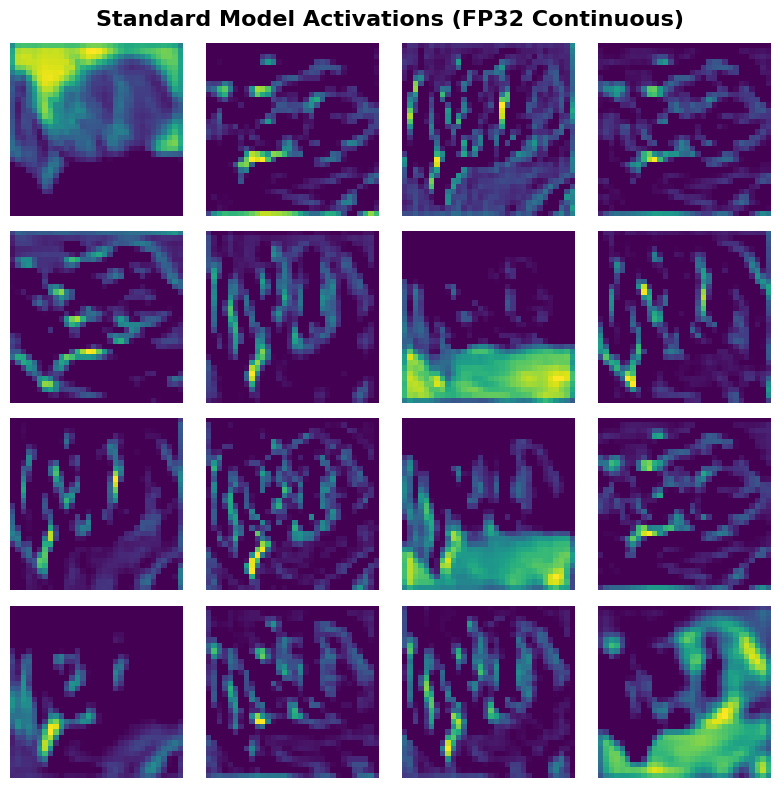

Generating Quantized Model feature maps...
Saved plot to: quantized_activations.png


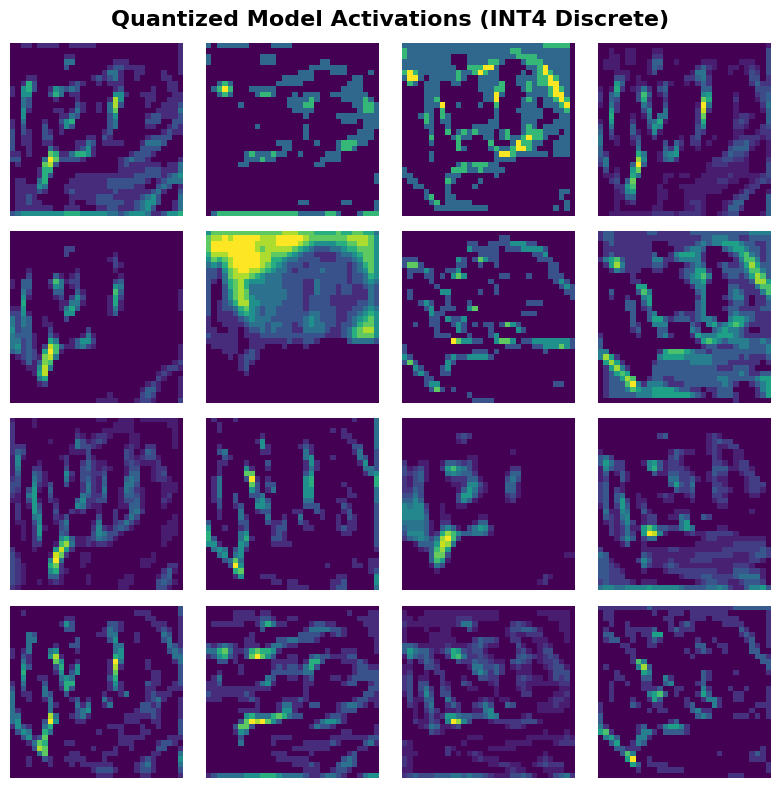

In [53]:
# Grab the very first image from our sample batch to visualize
image_to_visualize = sample_images[0]

print("Generating Standard Model feature maps...")
plot_feature_maps(
    loaded_std_model, 
    image_to_visualize, 
    "Standard Model Activations (FP32 Continuous)", 
    "standard_activations.png"  # File name for the standard model
)

print("Generating Quantized Model feature maps...")
plot_feature_maps(
    loaded_qnt_model, 
    image_to_visualize, 
    "Quantized Model Activations (INT4 Discrete)", 
    "quantized_activations.png" # File name for the quantized model
)

In [98]:
import os
import gc
import time
import threading
import statistics
import psutil
import tensorflow as tf
import matplotlib.pyplot as plt

# ==========================================
# 4. Memory Profiling Utilities
# ==========================================
def peak_rss_during(fn, interval=0.005):
    """Runs fn() while sampling RSS in a background thread. Returns (result, peak_mb)."""
    process = psutil.Process(os.getpid())
    peak = [process.memory_info().rss]
    stop_event = threading.Event()

    def sampler():
        while not stop_event.is_set():
            peak[0] = max(peak[0], process.memory_info().rss)
            time.sleep(interval)

    t = threading.Thread(target=sampler, daemon=True)
    t.start()
    result = fn()
    stop_event.set()
    t.join()
    return result, peak[0] / (1024 ** 2)


def profile_unified_memory(model, data_batch, model_name, n_trials=1000):
    process = psutil.Process(os.getpid())

    # Warm-up: stabilize TF graph allocation before measuring
    for _ in range(3):
        model.predict(data_batch[:1], verbose=0)

    times = []
    memory_deltas = []
    peak_memories = []

    for _ in range(n_trials):
        gc.collect()
        time.sleep(0.05)  # Let the OS settle RSS after GC

        # Reset TF peak memory tracker for this trial
        try:
            tf.config.experimental.reset_memory_stats('GPU:0')
        except Exception:
            pass

        mem_before = process.memory_info().rss / (1024 ** 2)

        t0 = time.perf_counter()
        _, peak_mb = peak_rss_during(
            lambda: model.predict(data_batch, batch_size=256, verbose=0)
        )
        t1 = time.perf_counter()

        mem_after = process.memory_info().rss / (1024 ** 2)

        times.append(t1 - t0)
        memory_deltas.append(mem_after - mem_before)
        peak_memories.append(peak_mb - mem_before)  # Peak spike above baseline

        # Capture TF allocator stats (more precise than RSS)
        try:
            tf_mem = tf.config.experimental.get_memory_info('CPU:0')
            tf_peak_mb = tf_mem['peak'] / (1024 ** 2)
        except Exception:
            tf_peak_mb = None

    print(f"--- {model_name} ({n_trials} trials) ---")
    print(f"  Inference Time   │ median: {statistics.median(times):.4f}s  stdev: {statistics.stdev(times):.4f}s")
    print(f"  RSS Delta        │ median: {statistics.median(memory_deltas):.4f} MB  stdev: {statistics.stdev(memory_deltas):.4f} MB")
    print(f"  Peak RSS Spike   │ median: {statistics.median(peak_memories):.4f} MB  stdev: {statistics.stdev(peak_memories):.4f} MB")
    if tf_peak_mb is not None:
        print(f"  TF Alloc Peak    │ {tf_peak_mb:.4f} MB  (last trial, most precise)")
    print()

# ==========================================
# 5. Run the Profiler
# ==========================================
test_batch = x_test[:1000]

print("Profiling Standard CNN...")
profile_unified_memory(loaded_std_model, test_batch, "Standard FP32 Model")

print("Profiling Quantized CNN...")
profile_unified_memory(loaded_qnt_model, test_batch, "Quantized INT4 Model")

Profiling Standard CNN...
--- Standard FP32 Model (1000 trials) ---
  Inference Time   │ median: 0.0616s  stdev: 0.0058s
  RSS Delta        │ median: 0.0312 MB  stdev: 1.2128 MB
  Peak RSS Spike   │ median: 0.3438 MB  stdev: 0.2543 MB

Profiling Quantized CNN...
--- Quantized INT4 Model (1000 trials) ---
  Inference Time   │ median: 0.1198s  stdev: 0.0110s
  RSS Delta        │ median: 0.0469 MB  stdev: 2.3385 MB
  Peak RSS Spike   │ median: 0.3594 MB  stdev: 2.3264 MB

